<div class="notebook-quickstart">
<h3>Quickstart</h3>
To run the code below:
<ol>
<li>Click on the cell to select it.</li>
<li>Press <code>SHIFT+ENTER</code> on your keyboard or press the play button
   (<button class='fa fa-play icon-play btn btn-xs btn-default'></button>) in the toolbar above</li>
</ol>
Feel free to create new cells using the plus button
(<button class='fa fa-plus icon-plus btn btn-xs btn-default'></button>), or pressing <code>SHIFT+ENTER</code> while this cell
is selected.
</div>

One of the great advantages of using Brian is that defining new non-standard model types is easy. In this article, we will build a highly simplified model of the pyloric circuit of the crustacean stomatogastric ganglion. This circuit generates a tri-phasic rhythmic pattern with alternating bursts of action potentials in different types of motor neurons. Here, we follow previous work (e.g. Golowasch et al., 1999) by modeling the circuit as consisting of three populations: AB/PD (anterior buster and pyloric dilator neurons), LP (lateral pyloric neurons), and PY (pyloric neurons). This model has a number of non-standard properties that will be described in the following annotated version of the code.

> Golowasch, J., Casey, M., Abbott, L. F., & Marder, E. (1999).  
> Network Stability from Activity-Dependent Regulation of Neuronal Conductances.  
> Neural Computation, 11(5), 1079-1096.  
> https://doi.org/10.1162/089976699300016359
    
This article was based on one of the examples from our eLife paper [(Stimberg et al. 2019)](https://elifesciences.org/articles/47314).

Before describing a model, we set up the Brian simulator:

In [1]:
from brian2 import *
%matplotlib notebook

We now enable the high-performance "standalone-mode". By default, the first run statement the code encounters will trigger the automatic compilation and execution. We disable this feature here (`build_on_run=False`) because our model consists of a sequence of runs. Only after all runs have been defined, we ask Brian to build and execute the simulation code.

In [2]:
set_device('cpp_standalone', build_on_run=False, directory=None)

To make simulation runs reproducible, we set the seed of the random number generator.

In [3]:
seed(123456)

All operations in Brian take place on "clocks" that step forward with given time steps. If not defined otherwise (as in this script), operations use the "default clock". We set its time step to 0.01ms:

In [4]:
defaultclock.dt = 0.01*ms

The neuron's membrane potential in the pyloric network shows slow oscillations with burst of action potentials at its peak. Here, we use a variant of the Hindmarsh-Rose model, reformulated to use physical dimensions instead of unitless variables. This model defines the dynamics of the membrane potential $v$, and of the adaptation variables $w$ and $x$ as follows:
$$
\frac{\mathrm{d}v}{\mathrm{d}t} = \left(\Delta_Tg\left(-a\left(v - v_T\right)^3 + b\left(v - v_T\right)^2\right) + w - x - I_\mathrm{fast} - I_\mathrm{slow}\right)\frac{1}{C} \\
\frac{\mathrm{d}w}{\mathrm{d}t} = \left(c - d\left(v - v_T\right)^2 - w\right)\frac{1}{\tau} \\
\frac{\mathrm{d}x}{\mathrm{d}t} = \left(s\left(v - v_r\right) - x\right)\frac{1}{\tau_x}
$$

In Brian, such equations can be specified as a string, following mathematic notation as closely as possible. The physical dimensions of the variable defined in the respective line has to be specified after a colon; this allows Brian to check for the consistency of the dimensions and therefore avoid the use of incorrect equations:

In [5]:
eqs = '''
dv/dt = (Delta_T*g*(-a*(v - v_T)**3 + b*(v - v_T)**2) + w - x - I_fast - I_slow)/C : volt
dw/dt = (c - d*(v - v_T)**2 - w)/tau : amp
dx/dt = (s*(v - v_r) - x)/tau_x : amp
'''

One particular feature of the pyloric network model in Golowasch et al. (1999) is that not all intrinsic conductances are constant, but some are activity-dependent via the Calcium current. Here, we simplify this dependency by having a Calcium signal that exponentially decays in the absence of spikes (it increases with each spike, see definition later in the script):
$$
\frac{\mathrm{d}Ca}{\mathrm{d}t} = -\frac{Ca}{\tau_{Ca}}
$$

In [6]:
eqs += '''
dCa/dt = -Ca/tau_Ca : 1
'''

Note that this Calcium signal is normalized and therefore dimensionless. We now follow the model of Golowasch et al. (1999) to describe the dependency of two conductances, $s$ and $g$ in our case, on the difference of this Calcium current to a target current via the dynamic variable $z$:
$$
\frac{\mathrm{d}z}{\mathrm{d}t} = \tanh\left(Ca - Ca_\mathrm{target}\right)\frac{1}{\tau_z}\\
s = S\left(1 - \tanh(z)\right)\\
g = G\left(1 + \tanh(z)\right)
$$

In [7]:
eqs += '''
s = S*(1 - tanh(z)) : siemens
g = G*(1 + tanh(z)) : siemens
dz/dt = tanh(Ca - Ca_target)/tau_z : 1
'''

Finally, we note that $I_\mathrm{fast}$ and $I_\mathrm{slow}$ are neuron-specific state variables (set by the Synapses later), and that $Ca_\mathrm{target}$ is a neuron-specific constant. We also add a special integer constant called `label` that will be used to label AB/PD, LP, and PY neurons.

In [8]:
eqs += '''
I_fast : amp
I_slow : amp
Ca_target : 1 (constant)
label : integer (constant)
'''

Our equations refer to a number of constants that are shared across all neurons, we define them as standard Python variables. 

In [9]:
init_time = 2.5*second
observe_time = 4*second
adapt_time = 49 * second
Delta_T = 17.5*mV
v_T = -40*mV
tau = 2*ms
tau_adapt = .02*second
tau_Ca = 150*ms
tau_x = 2*second
v_r = -68*mV
a = 1/Delta_T**3
b = 3/Delta_T**2
d = 2.5*nA/Delta_T**2
C = 60*pF
S = 2*nA/Delta_T
G = 28.5*nS
tau_z = 5*second
c = 1.2*nA
ABPD, LP, PY = 0, 1, 2  # Arbitrary numbers

Now, we create the neurons that follow the previously defined model, and additionally define what should count as a threshold crossing (`threshold`) and what should happen when it is crossed (`reset`). Note that this model describes the trajectory of the membrane potential during an action potential as part of its equations, it therefore does not reset the membrane potential after a spike as an integrate-and-fire model would. To prevent repeatedly triggering "spikes" due to the fact that the membrane potential is above the threshold all the time during the action potential, we state that while the neuron is still above the threshold, it should be considered not able to elicit any more spikes (`refractory`). Finally, we define the numerical integration method to use (`method`), here, a 2nd order Runge-Kutta method.

In [10]:
circuit = NeuronGroup(3, eqs, threshold='v>-20*mV', refractory='v>-20*mV', method='rk2',
                      reset='Ca += 0.1')

We've defined a group of three neurons, each one being of a different type. We set the neurons' label accordingly and set the initial conditions for the variables $v$, $w$, and $z$, as well as the neuron-type dependent values for the constant $Ca_\mathrm{target}$:

In [11]:
circuit.label = [ABPD, LP, PY]
circuit.v = v_r
circuit.w = '-5*nA*rand()'
circuit.z = 'rand()*0.2 - 0.1'
circuit.Ca_target = [0.048, 0.0384, 0.06]

The predefined `rand()` function returns random number from a uniform distribution between 0 and 1, i.e. $w$ is initialized to be between 0nA and -5nA, and $z$ between -0.1 and 0.1.

For this model, we want to describe two classes of synapses, "fast" and "slow". Both synaptic currents are graded functions of the presynaptic membrane potential. For the fast synapses, the current is an instantaneous function of both the pre-synaptic and the post-synaptic membrane potential:

In [12]:
# Synapses
eqs_fast = '''
g_fast : siemens (constant)
I_fast_post = g_fast*(v_post - E_syn)/(1+exp(s_fast*(V_fast-v_pre))) : amp (summed)
'''
fast_synapses = Synapses(circuit, circuit, model=eqs_fast)

The `(summed)` here means that the post-synaptic current will be summed over all currents from synapses targetting the same post-synaptic target. As for neurons, we then define general constants as Python variables:

In [13]:
s_fast = 0.2/mV
V_fast = -50*mV
s_slow = 1/mV
V_slow = -55*mV
E_syn = -75*mV
k_1 = 1/ms

To establish synapses between the neurons, we can provide a logical condition detailing whether a connection should be created for a specific pair of neurons. This condition can refer to arbitrary pre- and post-synaptic variables or constants. In the following, we make use of the `label` constant that defines the type of each neuron. Given that our simple model only includes one neuron of each type, we could have used the neuron indices instead. However, using a label has the advantage of clearly showing the intent behind the connection pattern and would automatically generalize to a network with multiple neurons per type. Here, we want to establish connections with fast synapses for all pairs of neurons with different type (i.e., don't connect neurons of the same type to each other), but not from PY to AB/PD neurons: 

In [14]:
fast_synapses.connect('label_pre != label_post and not (label_pre == PY and label_post == ABPD)')

The maximum conductance of each synapse depends on the pre- and post-synaptic neuron types, we assign them accordingly:

In [15]:
fast_synapses.g_fast['label_pre == ABPD and label_post == LP'] = 0.015*uS
fast_synapses.g_fast['label_pre == ABPD and label_post == PY'] = 0.005*uS
fast_synapses.g_fast['label_pre == LP and label_post == ABPD'] = 0.01*uS
fast_synapses.g_fast['label_pre == LP and label_post == PY']   = 0.02*uS
fast_synapses.g_fast['label_pre == PY and label_post == LP']   = 0.005*uS

For the slow synapses, the post-synaptic current depends on the pre-synaptic membrane potential indirectly via the variable $m_\mathrm{slow}$ (its differential equation is solved via its analytical solution, requested by chosing `method='exact'`):

In [16]:
eqs_slow = '''
k_2 : 1/second (constant)
g_slow : siemens (constant)
I_slow_post = g_slow*m_slow*(v_post-E_syn) : amp (summed)
dm_slow/dt = k_1*(1-m_slow)/(1+exp(s_slow*(V_slow-v_pre))) - k_2*m_slow : 1 (clock-driven)
'''
slow_synapses = Synapses(circuit, circuit, model=eqs_slow, method='exact')

Slow synapses are only arising from AB/PD units, and target neurons of all other types:

In [17]:
slow_synapses.connect('label_pre == ABPD and label_post != ABPD')

Their maximum conductance depends on the type of the target cell:

In [18]:
slow_synapses.g_slow['label_post == LP'] = 0.025*uS
slow_synapses.k_2['label_post == LP']    = 0.03/ms
slow_synapses.g_slow['label_post == PY'] = 0.015*uS
slow_synapses.k_2['label_post == PY']    = 0.008/ms

Before we start the simulation, we state what data we want to record during the simulation. In addition to the spiking activity, we record the membrane potential $v$ for all cells (`record=True`). By default, this monitor would use the same time resolution as the rest of the simulation (0.01 ms), but we reduce the resolution to 0.1ms:

In [19]:
M = StateMonitor(circuit, ['v'], record=True, dt=.1*ms)
spikes = SpikeMonitor(circuit)

To make analysis and plotting easier, we run the simulations in separate parts with the recording initally switched off (`M.active = false`). After a short period (`init_time`) we record the activity for a fixed period (`observe_time`). We then let the network adapt its conductances for a long time (`adapt_time`), without recording its activity. Finally, we record the activity in the adaptated network.

In [20]:
M.active = False
run(init_time, report='text')
M.active = True
run(observe_time, report='text')
M.active = False
run(adapt_time, report='text')
M.active = True
run(observe_time, report='text')

In the computationally efficient "standalone mode", the above statements describe the simulation protocol without actually launching the compilation and execution process. We do this now:

In [21]:
device.build()

After the simulation finished, we extract the spike trains from the monitor (spiking activity for each neuron) and plot the membrane potential and the spike trains of the three cell types before and after the adaption.

In [22]:
spike_trains = spikes.spike_trains()

<IPython.core.display.Javascript object>


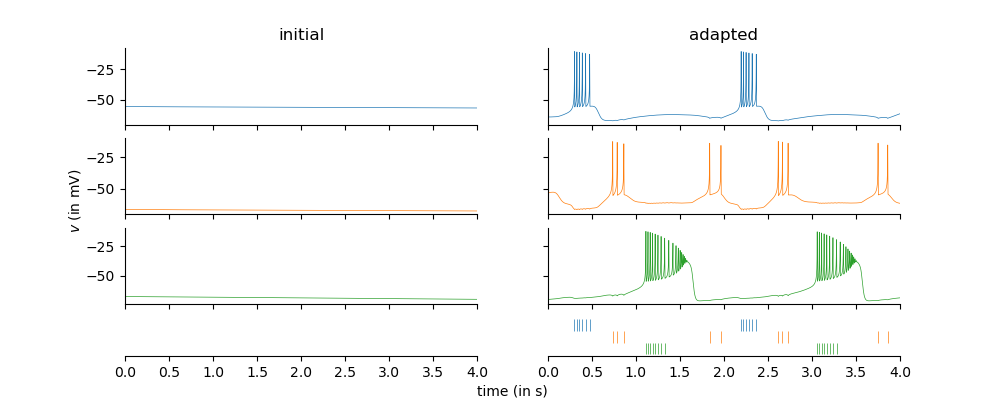

In [23]:
plt.rcParams.update({'axes.spines.right' : False, 'axes.spines.top': False})
fig, axes = plt.subplots(4, 2, sharex='col', sharey='row',
                             gridspec_kw={'height_ratios': [2, 2, 2, 1]},
                        figsize=(10, 4))
for idx, (label, color) in enumerate(zip(['AB/PD', 'LP', 'PY'],
                                         ['C0', 'C1', 'C2'])):
    axes[idx, 0].plot((M.t - init_time) / second, M.v[idx] / mV, label=label, color=color, lw=0.5)
    axes[3, 0].vlines((spike_trains[idx] - init_time) / second,
                      np.ones(len(spike_trains[idx]))*(3-idx)-0.5, np.ones(len(spike_trains[idx]))*(3-idx)+0.5,
                      color=color, lw=0.5)
    after_adapt_time = init_time + observe_time + adapt_time
    axes[idx, 1].plot((M.t - after_adapt_time) / second, M.v[idx] / mV, label=label, color=color, lw=0.5)
    axes[3, 1].vlines((spike_trains[idx] - after_adapt_time) / second,
                      np.ones(len(spike_trains[idx]))*(3-idx)-0.5, np.ones(len(spike_trains[idx]))*(3-idx)+0.5,
                      color=color, lw=0.5)

axes[0, 0].set(xlim=(0, observe_time/second), title='initial')
axes[0, 1].set(xlim=(0, observe_time/second), title='adapted')
axes[3, 0].set_yticks([])
axes[3, 0].spines['left'].set_visible(False)
axes[3, 1].spines['left'].set_visible(False)
axes[2, 0].set(xlabel='time (in s)', ylabel='$v$ (in mV)')
axes[2, 0].yaxis.set_label_coords(-0.12, 1.35)
axes[2, 0].xaxis.set_label_coords(1.1, -1.05);